<img align="right" style="max-width: 200px; height: auto" src="./fs_logo.png">

##  Lab 05 - Unsupervised Deep Learning

Seminar Künstliche Intelligenz, Frankfurt School, 2022

Die Analysen des Seminars **Künstliche Intelligenz** des Zertifikatstudiengangs **Certified Audit Data Scientist (CADS)** basieren auf Jupyter Notebook. Anhand solcher Notebooks ist es möglich eine Vielzahl von Datenanalysen und statistischen Validierungen durchzuführen.

<img align="center" style="max-width: 700px" src="./lab_05_banner.png">

Im letzten Lab haben Sie die verschiedenen Elemente eines Supervised Deep Learning Workflow kennengelernt z.B. Datenaufbereitung, Model Training und Validierung. In diesem fünften Lab werden wir Jupyter Notebook verwenden, um ein erstes **Deep Learning basiertes Audit-Analyseverfahren** zu implementieren und anzuwenden.

Hierzu werden wir die im Seminar vorgestellten Deep Autoencoder Neural Networks (AENNs) anwenden um Anomalien im Buchungsstoff einer Finanzbuchhaltung zu detektieren. Im Gegensatz zu klassischen Feedforward-Netzen lernen AENNs, die Eingabedaten in eine niedrig-dimensionale Repräsentation zu **encodieren**.  Gleichzeitig lernt das AENN, die ursprünglichen Daten wieder aus der enkodierten Repräsentation zu **dekodieren**. 

Die dekodierten Daten, die in der Regel als **Rekonstruktion** bezeichnet werden, sollten eine grosse Ähnlichkeit zu den ursprünglichen **Eingabedaten** aufweisen. Die Buchungssätze, für welche eine erfolgreiche Rekonstruktion nur fehlerhaft gelingt müssen deshalb eine oder mehrere ungewöhnliche Eigenschaften aufweisen. Die nachstehende Abbildung zeigt einen Überblick über den Deep Learning Prozess bzw. die AENN Netzarchitektur, welche wir in diesem Lab implementieren.

<img align="center" style="max-width: 900px" src="./assets/process.png">

Im Rahmen des Lab werden wir wieder einige Funktionen der `PyTorch` Bibliothek nutzen, um ein AENN zu implementieren und zu trainieren. Im Laufe des Trainingsprozess soll das AENN die charakteristische Eigenschaften historischer **Buchhaltungsdaten** bzw. **Journal Entries** lernen. Nach erfolgreichen Modelltraining, werden wir das Modell anwenden, um ungewöhnliche Journal Entries innerhalb des Datensatzes zu detektieren. Abschliessend werden wir die gelernten **Repräsentationen** der einzelnen Journaleinträge dazu verwenden, um die erhaltenen Ergebnisse zu interpretieren.

Bei etwaigen Fragen wenden Sie sich, wie immer gerne an uns via **marco (dot) schreyer (at) unisg (dot) ch**. Wir wünschen Ihnen Viel Freude mit unseren Notebooks und Ihren revisorischen Analysen!

## Lernziele des Labs:

Nach der heutigen Übung sollten Sie in der Lage sein:

>1. Die **Grundkonzepte, Funktionsweise und Bestandteile** von Autoencoder Neuronalen Netzen zu verstehen.
>2. Eine **Vorverarbeitung** von kategorischen Finanzdaten (One-Hot Encoding, Normalisierung) durchzuführen. 
>3. Autoencoder Neuronalen Netze anzuwenden, um **Anomalien** in umfangreichen Finanzdaten aufzuspüren.
>4. Die **Ergebnisse** bzw. den Rekonstruktionsfehler von Autoencoder Neuronalen Netzen zu interpretieren.

## 1. Einrichten der Analyseumgebung

Ähnlich wie in den vorangegangenen Übungen werden wir zunächst eine Reihe von Python-Bibliotheken importieren, welche die Datenanalyse und -visualisierung ermöglichen. In dieser Übung werden wir die Bibliotheken `PyTorch`, `Pandas`, `Numpy`, `Scikit-Learn`, `Matplotlib` und `Seaborn` verwenden. Nachfolgend importieren wir die benötigten Bibliotheken durch die Ausführung der folgenden Anweisungen:

In [4]:
# import python data science and utility libraries
import os, sys, itertools, urllib, io, warnings
import datetime as dt
import pandas as pd
import pandas_datareader as dr
import numpy as np

Import der `PyTorch` Deep Learning Bibliotheken:

In [5]:
# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

Import der `Matplotlib` und `Seaborn` Visualisierungs Bibliotheken und setzen der Visualisierungsparameter:

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

Ausschalten möglicher Warnmeldungen z.B. aufgrund von zukünftigen Änderungen der Bibliotheken:

In [7]:
# set the warning filter flag to ignore warnings
warnings.filterwarnings('ignore')

Aktivieren der sog. Inline-Darstellung von Visualisierungen in Jupyter-Notebook:

In [8]:
%matplotlib inline

Erstellen eine Struktur von Unterverzeichnissen innerhalb des aktuellen Arbeitsverzeichnisses für (1) das Speichern der Originaldaten, (2) der Analyseergebnisse und (2) für die trainierten Modelle:

In [9]:
# create the data sub-directory
data_directory = './01_data'
if not os.path.exists(data_directory): os.makedirs(data_directory)
    
# create the results sub-directory
results_directory = './02_results'
if not os.path.exists(results_directory): os.makedirs(results_directory)

# create the models sub-directory
models_directory = './03_models'
if not os.path.exists(models_directory): os.makedirs(models_directory) 

Festlegen eines zufälligen Seeds zur Gewährleistung der Reproduzierbarkeit:

In [10]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed cpu

Aktivieren des GPU Computing, durch setzen des `device` flag und setzen eines zufälligen `CUDA` Seeds:

In [11]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# set pytorch gpu seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] notebook with \'{}\' computation enabled'.format(str(now), str(device)))

[LOG 2022.10.06-15:30:41] notebook with 'cpu' computation enabled


Anzeige der Hardware Informationen über die ggf. verfügbare GPU(s):

In [12]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


Anzeige der Software Informationen über die verfügbaren `Python` bzw. `PyTorch` Versionen:

In [13]:
# print current Python version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 2022.10.06-15:32:18] The Python version: 3.10.6 (main, Aug 30 2022, 05:12:36) [Clang 13.1.6 (clang-1316.0.21.2.5)]


In [14]:
# print current PyTorch version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 2022.10.06-15:32:18] The PyTorch version: 1.12.1


## 2. Datenakquise und Datenaufbereitung

Heutzutage beschleunigen Unternehmen die Digitalisierung von Geschäftsprozessen, wovon auch Enterprise Resource Planning (ERP)-Systeme betroffen sind. Diese Systeme sammeln grosse Mengen Daten auf granularer Ebene. Dies gilt insbesondere für die Journalbuchungen einer Organisation, die innerhalb des Hauptbuch und den jeweiligen Nebenbüchern erfasst werden.

Die Darstellung in **Abbildung 1** zeigt eine hierarchische Ansicht eines ERP-Systems, das Journalbuchungen in Datenbanktabellen erfasst. Im Kontext revisorischer Prüfungen können die in solchen Systemen erfassten Daten wertvolle Hinweise auf mögliche dolose Handlungen enthalten.

<img align="middle" style="max-width: 800px; height: auto" src="./assets/accounting.png">

**Abbildung 1:** Hierarchische Ansicht eines Enterprise Resource Planning (ERP)-Systems, das Geschäftsvorfälle auf verschiedene Abstraktionsebenen in Datenbanktabellen erfasst, d.h. auf Ebene (1) des Geschäftsprozesses, (2) der Buchhaltung sowie (3) der Datenbank.

Zunächst werden den im Rahmen des Labs verwendeten Datensatzes deskriptiv analysieren. Außerdem werden wir die Daten vorverarbeiten um die Ausgangslage zu schaffen ein tiefes neuronales Netz zu trainieren. Der Lab Datensatz basiert auf einer angepassten Teilmenge des **"Synthetic Financial Dataset For Fraud Detection "** Datensatz von Lopez-Rojas. Der Originaldatensatz wurde ursprünglich über die Kaggle-Plattform für Data Science Wettbewerbe veröffentlicht und kann über den nachfolgenden Link abgerufen werden kann: https://www.kaggle.com/ntnu-testimon/paysim1.

In einem ersten Schritt laden wir den Datensatz in unsere Analyseumgebung:

In [17]:
# load the dataset into the notebook
url = 'https://raw.githubusercontent.com/GitiHubi/CADS/main/lab_05/fraud_dataset.csv'
ori_dataset = pd.read_csv(url)

Anschliessend prüfen wir die Dimensionalität des Datensatzes:

In [18]:
# inspect the datasets dimensionalities
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] transactional dataset of {} rows and {} columns retreived.'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 2022.10.06-16:21:28] transactional dataset of 91247 rows and 10 columns retreived.


Darüber hinaus speichern wir eine Sicherheitskopie des geladenen Datensatzes mit aktuellem Zeitstempel:

In [20]:
# determine current timestamp 
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

# define dataset filename 
filename = timestamp + " - original_fraud_dataset.xlsx"

# save dataset extract to the data directory
ori_dataset.head(1000).to_excel(os.path.join(data_directory, filename))

### 2.1 Initiales Daten Assessment

Der Datensatz enthält insgesamt **sieben kategorische** und **zwei numerische Attribute**, die den innerhalb des SAP FICO Moduls enthaltenen Tabellen BKPF (Buchungsbelegköpfe) und BSEG (Buchungsbelegsegmente) entsprechen. Die nachstehende Liste enthält einen Überblick über die einzelnen Attribute sowie eine kurze Beschreibung ihrer jeweiligen Semantik:

>- `BELNR`: die Nummer des Buchhaltungsbelegs,
>- `BUKRS`: der Buchungskreis
>- `BSCHL`: der Buchungsschlüssel,
>- `HKONT`: das gebuchte Hauptbuchkonto,
>- `PRCTR`: das gebuchte Profit Center,
>- `WAERS`: der Währungsschlüssel,
>- `KTOSL`: der Schlüssel des Hauptbuchkontos,
>- `DMBTR`: der Betrag in der Hauswährung,
>- `WRBTR`: der Betrag in der Belegwährung.

Sehen wir uns auch einmal die ersten 10 Zeilen des Datensatzes im Detail an:

In [21]:
# inspect top rows of dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,456737,C2,C23,C1,C10,A1,B1,64962.21,0.00,regular
1,87791,C6,C61,C5,C53,A2,B1,522465.43,522465.43,regular
2,104539,C3,C30,C1,C17,A3,B1,903760.72,571.00,regular
3,73560,C1,C12,C9,C95,A1,B1,252628.54,0.00,regular
4,48480,C2,C20,C1,C11,A1,B1,1231440.06,20363.00,regular
5,270089,C7,C71,C1,C14,A3,B1,230323.36,0.00,regular
6,272714,C1,C10,C1,C16,A1,B1,373399.70,0.00,regular
7,160295,C1,C14,C2,C27,A1,B3,888555.15,194811.00,regular
8,233425,C1,C15,C4,C40,A1,B3,2004667.92,31473.00,regular
9,136973,C6,C65,C3,C34,A2,B2,958050.23,112519.00,regular


Vielleicht ist Ihnen bei der Durchsicht der Attribute auch das Attribut mit der Bezeichung `Label` in den Daten aufgefallen. Dieses Attribut enthält die Ground-Truth Informationen zu den jeweils einzelnen Buchungen. Das Attribut beschreibt die 'wahre Natur' jeder Transaktion, d.h. ob es sich um eine **reguläre** Transaktion (gekennzeichnet durch `regulär`) oder eine **Anomalie** (gekennzeichnet durch `global` und `lokal`) handelt.  

Wir werden dieses Feld während des gesamten Labs verwenden, um die Qualität unserer trainierten Modelle zu bewerten. Bitte beachten Sie jedoch, dass uns eine solches Feld in der Realität nicht zur Verfügung stünde. Schauen wir uns nun einmal die Verteilung der regulären gegenüber den anomalen Transaktionen im Datensatz an:

In [22]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    91147
global        70
local         30
Name: label, dtype: int64

Die Analyse zeigt, dass wir es, ähnlich wie in der realen Welt, von einem sehr **unausgewogenen Datensatz** lernen werden. Insgesamt enthält der Datensatz nur einen sehr kleinen Anteil von **100 (0,109 %)** anomalen Transaktionen. Unter den 100 Anomalien befinden sich **70 (0,076 %)** *globale* Anomalien und **30 (0,003 %)** *lokale* Anomalien. 

In einem nächsten Schritt entfernen wir das `label` Attribut aus dem Trainingsdatensatz:

In [59]:
# remove the "ground-truth" label information for the following steps of the class
label = ori_dataset.pop('label')

### 2.2 Vorverarbeitung der Kategorischen Attribute

Aus der Sichtung der Daten geht hervor, dass die Mehrzahl der Attribute kategorische (diskrete) Attributwerte aufweisen, z.B. das Buchungsdatum, das Hauptbuchkonto, die Buchungsart und die Währung. Schauen wir uns nun die Verteilung der kategorischen Attribute *Buchungsschlüssel `BSCHL` sowie Hauptbuchkonto `HKONT` einmal im Detail an:

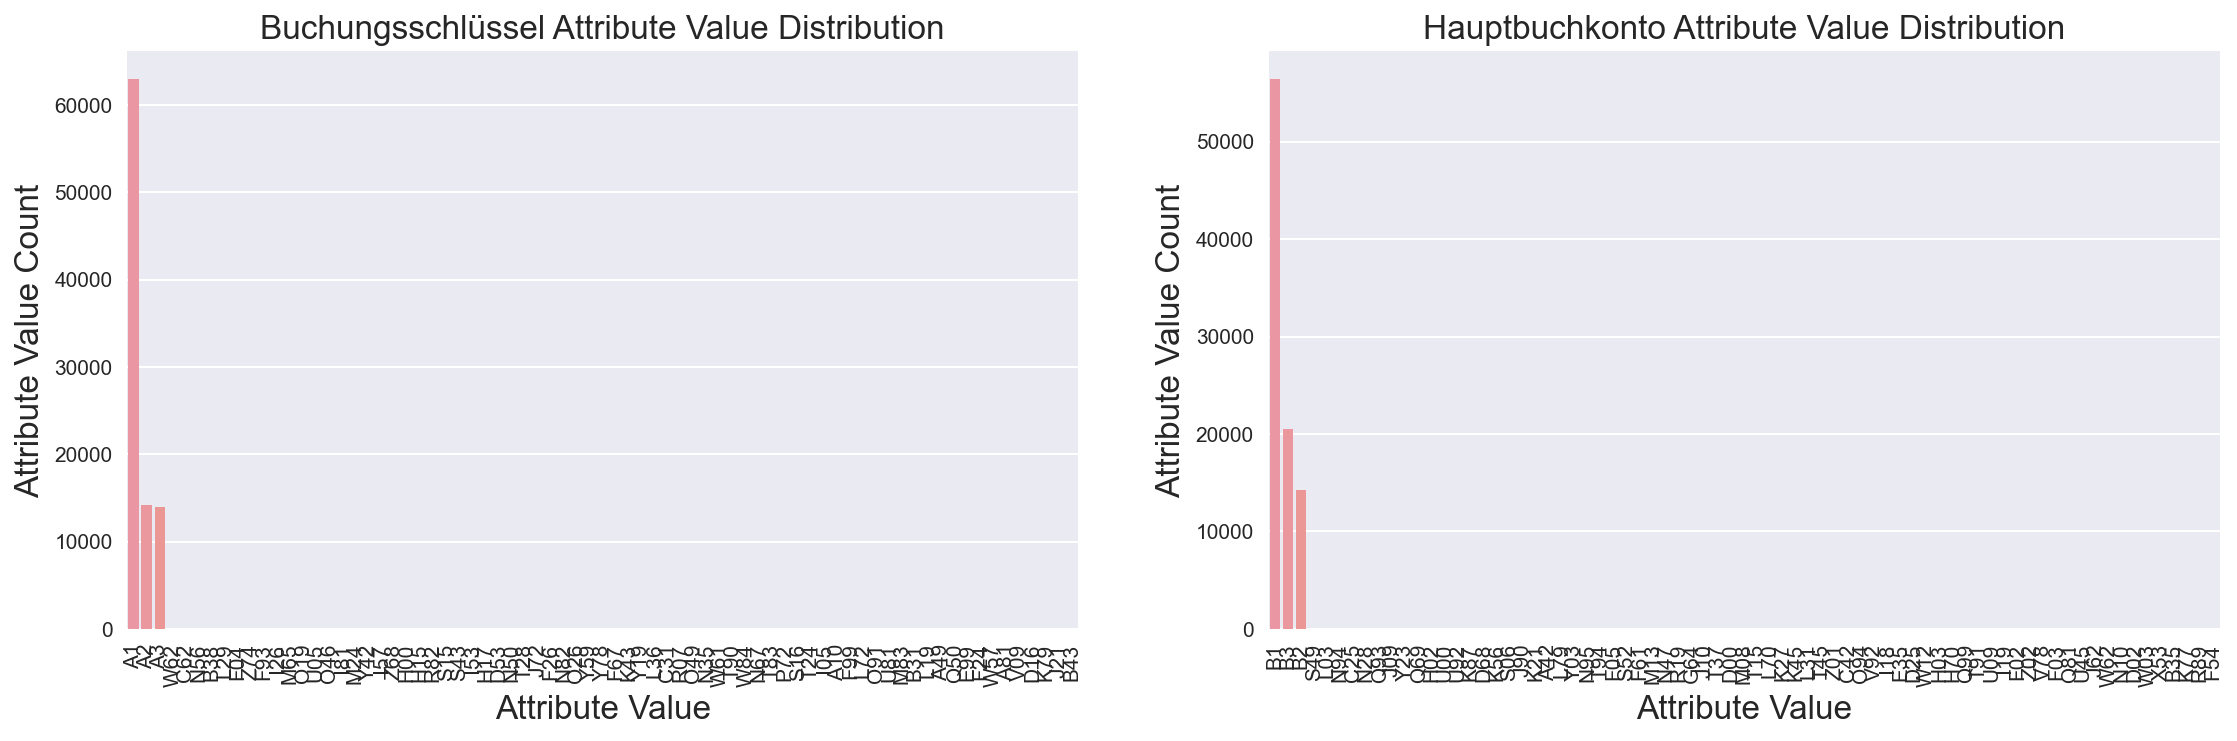

In [24]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(18)

# plot the distribution of the posting key attribute
plot = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])

# set axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Buchungsschlüssel Attribute Value Distribution', fontsize=16)

# plot the distribution of the general ledger attribute
plot = sns.countplot(x=ori_dataset['HKONT'], ax=ax[1])

# set axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Hauptbuchkonto Attribute Value Distribution', fontsize=16);

Im Allgemeinen sind Neuronale Netze dafür konzipiert numerische Daten zu verarbeiten. Eine einfache Möglichkeit, diese Anforderung zu erfüllen, ist die Anwendung eines Verfahrens, das als sog. **One-Hot Kodierung** bezeichnet wird. Hierdurch kann eine numerische Darstellung kategorischer Attributwerte abgeleitet werden. Bei der **One-Hot Kodierung** wird für jeden kategorischen Attributwert eine zusätzliche binäre Spalte in den Daten erstellt. 

Schauen wir uns hierzu das Beispiel in **Abbildung 2** unten an. Das kategorische Attribut **Receiver** in den Orginaldaten enthält die Namen 'Sally', 'John' und 'Emma'. Wir kodieren das Attribut als 'one-hot' Attribut, indem wir eine zusätzliche binäre Spalte für jeden kategorischen Wert in der Spalte 'Receiver' erstellen. Anschliessend kodieren wir z.B. jede Transaktion, die den Wert 'Sally' in der Spalte 'Receiver' aufweist mit dem Wert 1.0 innerhalb der 'Sally' Spalte der Transaktion. Sollte eine Transaktion einen anderen Wert in der Spalte 'Receiver' aufweisen, kodieren wir die 'Sally' Spalte mit dem Wert 0.0. 

<img align="middle" style="max-width: 600px; height: auto" src="./assets/encoding.png">

**Abbildung 2:** Beispielhafte 'One-Hot' Kodierung der verschiedenen Receiver Attributwerte in spezifische binäre 'One-Hot' Spalten. Dabei resultiert jeder im Datensatz beobachtbare Attributwert in einer eigene Spalte. Der Spaltenwert **1.0** kodiert das Vorkommen des Attributwertes in der entsprechenden Buchung. Der Spaltenwert **0.0** hingegen zeigt, dass der Attributwert nicht innerhalb der entsprechenden Buchung vorkommt.

Anhand dieses Verfahrens können die insgesamt sechs kategorischen Attribute des Datensatzes in numerische Attribute überführt werden. Die `Pandas` Bibliothek stellt hierzu die entsprechende Funktionalität zur Verfügung, welche wir im Nachfolgenden anwenden:

In [25]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['BUKRS', 'KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_cat_processed = pd.get_dummies(ori_dataset[categorical_attr_names])

Nachfolgend überprüfen wie die vorgenommene **One-Hot Kodierung** anhand der 10 ersten Buchungen des Datensatzes:

In [26]:
# inspect encoded sample transactions
ori_dataset_cat_processed.head(10)

,BUKRS_A43,BUKRS_A89,BUKRS_B37,BUKRS_B76,BUKRS_C10,BUKRS_C11,BUKRS_C12,BUKRS_C13,BUKRS_C14,BUKRS_C15,...,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3 Vorverarbeitung der numerischen Attribute

Anschliessend Analysieren wir nun die Verteilungen der **beiden numerischen Attribute** des Datensatzes. Hierbei handelt es sich um die Attribute (1) *Betrag in Hauswährung* `DMBTR` und (2) *Betrag in Dokumentwährung* `WRBTR` deren jeweilge Verteilungen wir nachfolgend visualisieren: 

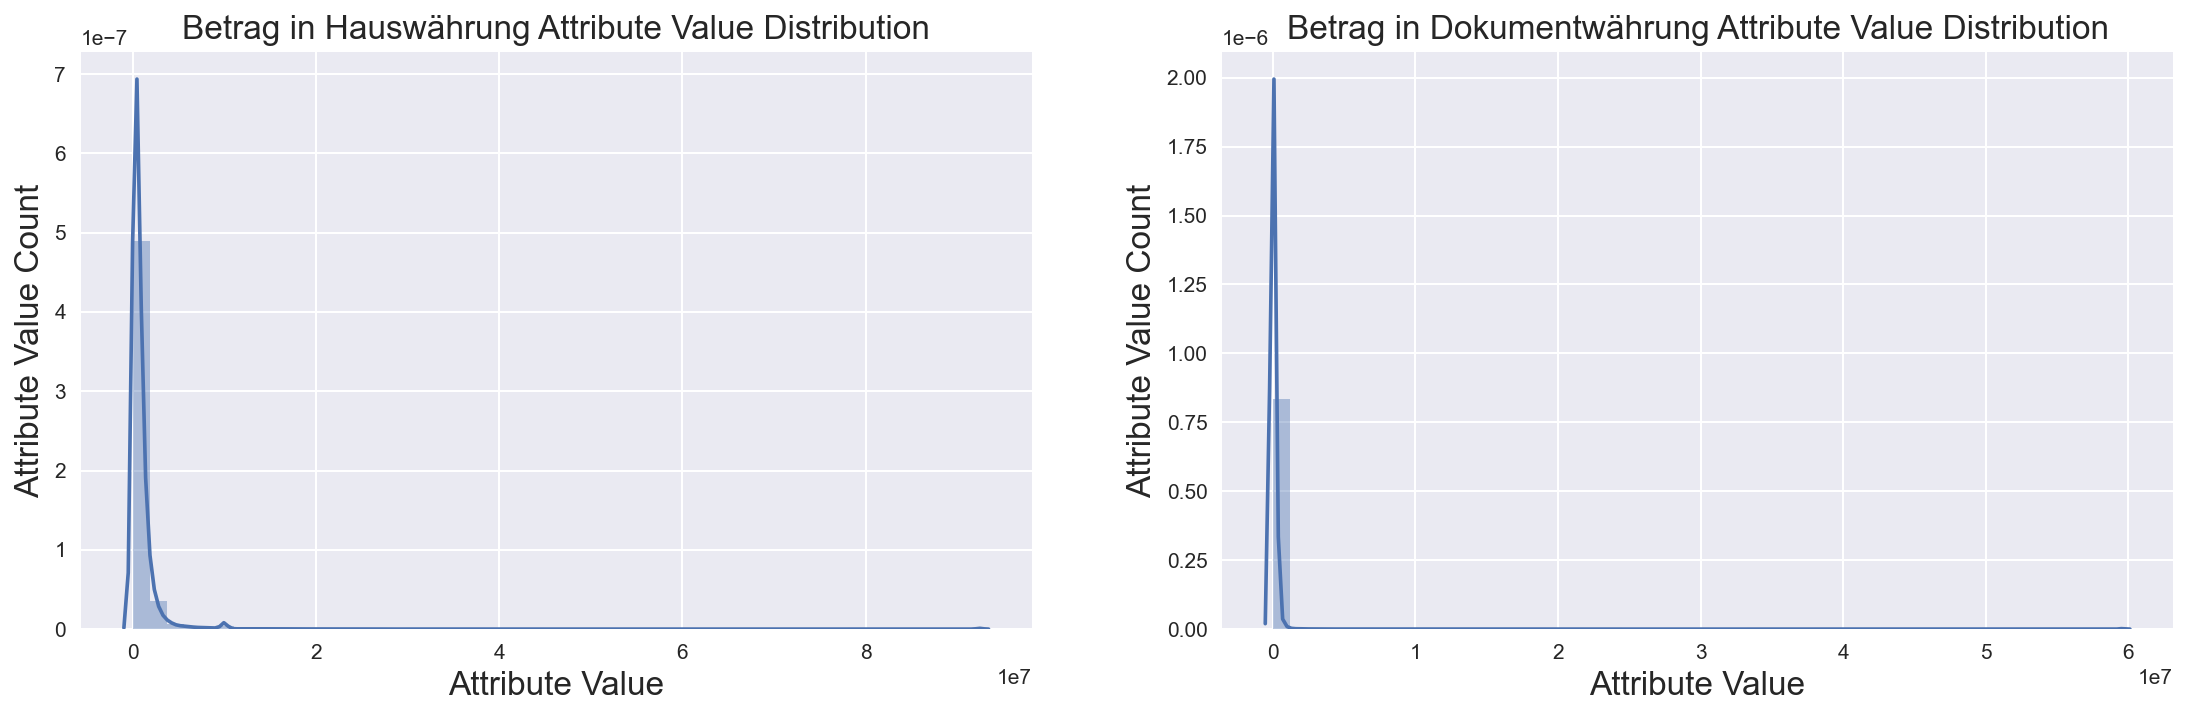

In [28]:
# plot the log-scaled 'DMBTR' as well as the 'WRBTR' attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(18)

# plot distribution of the local amount attribute
plot = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Betrag in Hauswährung - Attribute Value Distribution', fontsize=16)

# plot distribution of the document amount attribute
plot = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Betrag in Dokumentwährung - Attribute Value Distribution', fontsize=16);

Die Werte beider Betragsattribute weisen eine jeweils **schiefe** und **steile** Verteilung auf. Wir skalieren deshalb die Werte zunächst logarithmisch. Anschliessend min-max normalisieren wir die Skalierten Werte:

In [29]:
# select the 'DMBTR' and 'WRBTR' attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7

# log scale the 'DMBTR' and 'WRBTR' attribute values
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_num_processed = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

In einem nächsten Schritt visualisieren wir die Verteilungen der skalierten bzw. normierten Werte beider Betragsattribute:

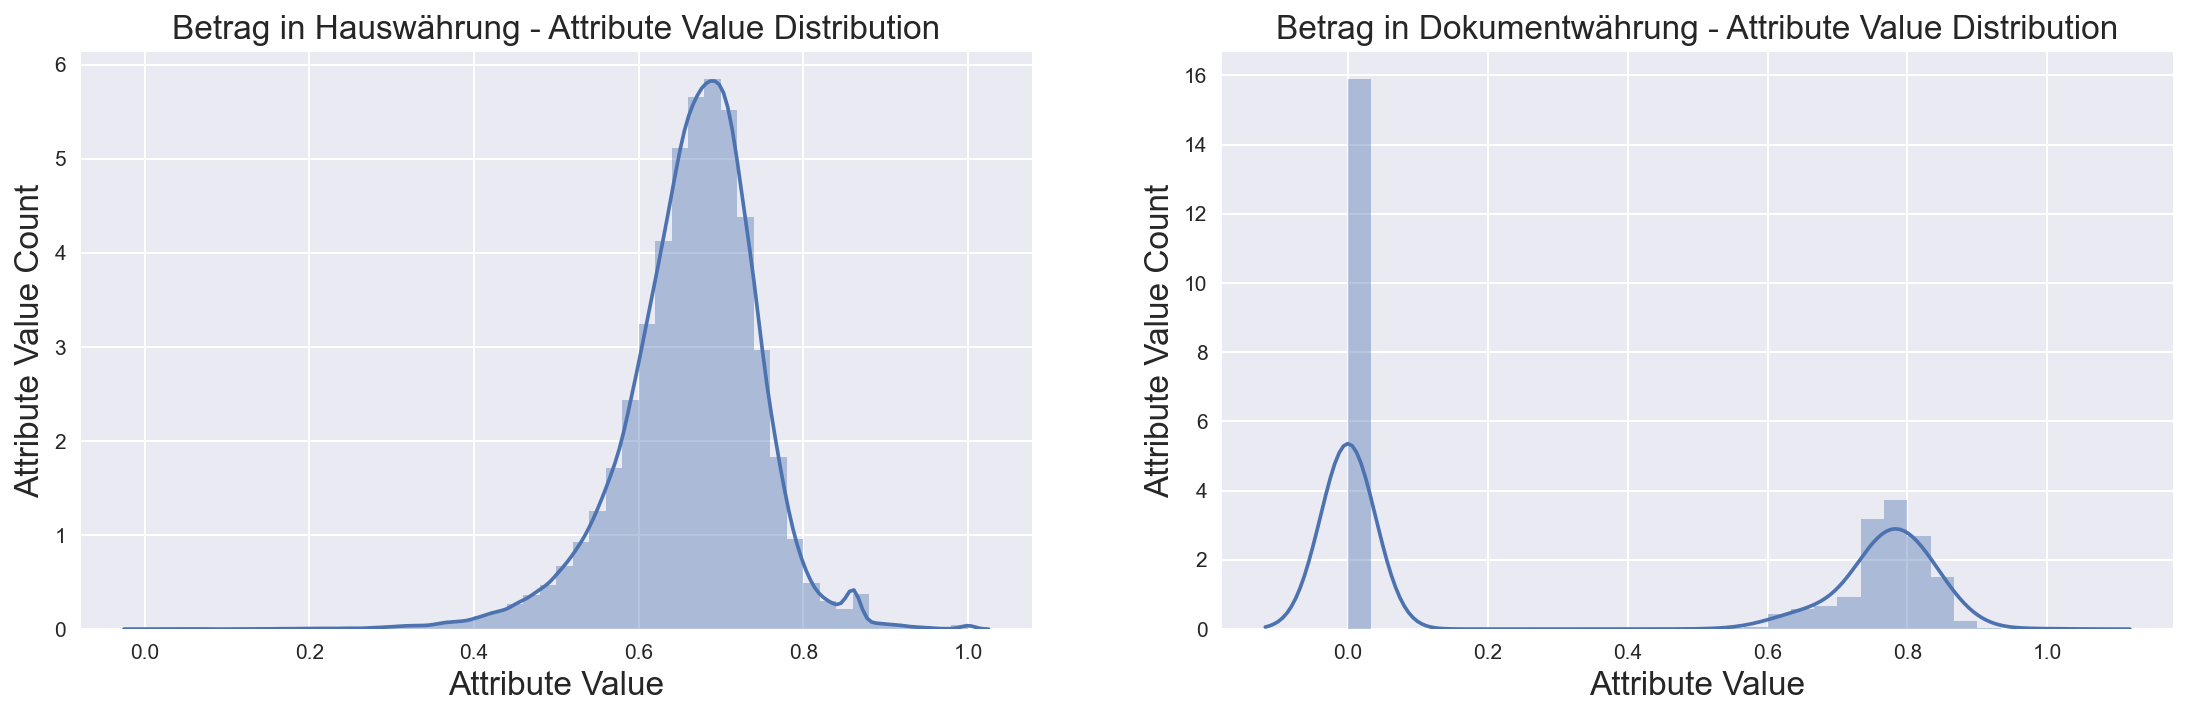

In [31]:
# plot the log-scaled 'DMBTR' as well as the 'WRBTR' attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(18)

# plot distribution of the local amount attribute
plot = sns.distplot(ori_dataset_num_processed['DMBTR'].tolist(), ax=ax[0])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Betrag in Hauswährung - Attribute Value Distribution', fontsize=16)

# plot distribution of the document amount attribute
plot = sns.distplot(ori_dataset_num_processed['WRBTR'].tolist(), ax=ax[1])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Betrag in Dokumentwährung - Attribute Value Distribution', fontsize=16);

### 2.4 Merge Categorical and Numerical Transaction Attributes

Abschliessend fügen wir die beiden vorverarbeiteten numerischen und kategorischen Attribute zu einem **einzigen Datensatz** zusammen. Der zusammengeführte Datensatz bildet die Grundlage für das Training des Deep Autoencoder Neural Networks (AENNs):

In [32]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_cat_processed, ori_dataset_num_processed], axis = 1)

Werfen wir nun noch einen finalen einen Blick auf die Dimensionalität des zusammengefügten Datensatzes:

In [33]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(91247, 618)

Nach Abschluss der Vorverarbeitungsschritte erhalten wir einen Datensatz, der aus einer Gesamtzahl von **91.147 Datensätzen** (Zeilen) und **618 Attributen** (Spalten) besteht. Wir behalten die Spalten im Hinterkopf, da sie die Dimensionalität der Eingabe- und Ausgabeschicht unseres AENNs bestimmt.

## 3. Autoencoder Neural Network Implementierung

The objective of this master class section is to familiarise ourselves with the underlying idea and concepts of building a deep **Autoencoder Neural Network (AENN)**. We will cover the primary building blocks and the specific network structure of AENNs as well as an exemplary implementation using the open-source machine learning library `PyTorch`.

### 4.1 Autoencoder Neural Network Architektur

AENNs oder 'Replicator Neural Networks' sind eine **Unsupervised Learning** Variante Aufbauend auf klassischen Feed-Forward-Netzen. Die Architektur wurde ursprünglich von Goeffery Hinton und Ruslan Salakhutdinov entwickelt. AENNs bestehen in der Regel aus einer **symmetrischen Netzarchitektur** sowie einer zentralen verborgenen Schicht, die als **latente** oder **engpass Schicht** bezeichnet wird. Diese Schicht weist eine geringere Dimensionalität als die Eingabeschicht auf. Das Lernziel des AENN besteht darin, die ursprünglichen Eingabedaten an der Ausgabeschicht möglichst fehlerfrei zu rekonstruieren. **Abbildung 3** zeigt eine schematische Darstellung eines Autoencoder Neural Network:

<img align="middle" style="max-width: 800px; height: auto" src="./assets/autoencoder.png">

**Abbildung 3:** Schematische Darstellung eines Autoencodernetzes, das aus zwei nichtlinearen Abbildungen (von fully-connected Feed-Forward-Netze) besteht. Die beiden miteinander verknüpften Netze werden als Encoder $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$ und Decoder $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dx}$ bezeichnet.

Grundsäzlich können AENNs als 'verlustbehaftete' **Komprimierungsalgorithmen** interpretiert werden. Sie sind 'verlustbehaftet' in dem Sinne, dass die rekonstruierten Ausgaben im Vergleich zu den ursprünglichen Eingaben Fehler aufweisen können. Die Differenz zwischen der ursprünglichen Eingabe $x^i$ und ihrer Rekonstruktion $\hat{x}^i$ wird als **Rekonstruktionsfehler** bezeichnet. Im Allgemeinen bestehen AENNs aus drei Hauptbestandteilen:

> 1. einer enkodierendes Funktion $f_\theta$, 
> 2. einer dekodierendes Funktion $g_\theta$, und
> 3. einer Fehlerfunktion $\mathcal{L_{\theta}}$.

Im Kontext des Deep Learning besteht die enkodierende bzw. dekodierende Funktion jeweils aus einem Neuronalen Netz mit zu lernenden Parametern $\theta$. Das **Encodernetz $f_\theta(\cdot)$** bildet einen Eingabevektor (z.B. eine Buchung der Finanzbuchhaltung) $x^i$ auf eine komprimierte (d.h. niedrig dimensionale) Repräsentation $z^i$ ab im sog. latenten Raum $Z$ ab. Die niedrig-dimensionale Repräsentation $z^i$ wird anschliessend durch das **Decodernetz** $g_\theta(\cdot)$ auf einen Ausgabevektor $\hat{x}^i$ des ursprünglichen Eingaberaums (z.B. die rekonstruierte Buchung der Finanzbuchhaltung) abgebildet. Formal können diese jeweils oftmals **nicht-linearen Abbildungen** der beiden Funktion wie nachfolgend definiert werden:

<center>$f_\theta(x^i) = s(Wx^i + b)$ &emsp; $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$,</center>
<center>$g_\theta(z^i) = s′(W′z^i + d)$ &emsp; $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dx}$,</center>

wobei die beiden Funktionen die zu lernenden Modellparameter $\theta = \{W, b, W', d\}$ aufweisen. Die Parameter $W \in \mathbb{R}^{d_x \times d_z}, W' \in \mathbb{R}^{d_z \times d_y}$ bezeichnen die Gewichtsmatrizen, die Parameter $b \in \mathbb{R}^{dx}$, $d \in \mathbb{R}^{dz}$ die Bias-Vektoren der Netze, und $s$ bzw. $s′$ die jeweils nicht-linearen Aktivierungsfunktionen. 

### 4.2 Autoencoder Neural Network Implementierung

In einem nächsten Schritt möchten wir nun das Encoder Netz in `PyTorch` implementieren. Der Encoder soll aus insgesamt **neun fully-connected Schichten** künstlicher Neuronen bestehen. Darüber hinaus solle der Encoder die nachfolgende Anzahl von Neuronen pro Schicht enthalten: 618-256-128-64-32-16-8-4-3. Die Notation vorhergehende Notation bedeutet, dass die erste Schicht 618 Neuronen umfasst (bestimmt durch die Dimensionalität der Eingabedaten), die zweite Schicht 256 Neuronen und die weiteren Schichten 128, 64, 32, 16, 8, 4 bzw. 3 Neuronen.

<img align="middle" style="max-width: 1000px; height: auto" src="./assets/neurons.png">

Den nachfolgenden drei Elementen der Implementierung des Encoder Netzes möchten wir eine besonderes Augenmerk schenken:

>- `self.encoder_Lx`: definiert die lineare Transformation der jeweiligen Schicht, welche auf die Eingabe angewandt wird: $Wx + b$.
>- `nn.init.xavier_uniform`: initialisiert Gewichtsparameter anhand einer gleichmäßigen Xavier Verteilung. 
>- `self.encoder_Rx`: definiert die nicht-lineare Transformation der jeweiligen Schicht, welche auf die Eingabe angewandt wird: $\sigma(\cdot)$.

Wir verwenden sog. **Leaky ReLUs**, um sog. "sterbende" Neuronen zu vermeiden und die Trainingskonvergenz zu beschleunigen. Leaky ReLUs ermöglichen kleine Gradienten innerhalb des negativen Bereichs der Aktivierungsfunktion (siehe Schaubild oben).

In [35]:
# implementation of the encoder network
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 512
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=512, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 512, out 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 256, out 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 128, out 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 64, out 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 32, out 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 16, out 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 8, out 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 4, out 3
        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x))
        x = self.encoder_R2(self.encoder_L2(x))
        x = self.encoder_R3(self.encoder_L3(x))
        x = self.encoder_R4(self.encoder_L4(x))
        x = self.encoder_R5(self.encoder_L5(x))
        x = self.encoder_R6(self.encoder_L6(x))
        x = self.encoder_R7(self.encoder_L7(x))
        x = self.encoder_R8(self.encoder_L8(x))
        x = self.encoder_R9(self.encoder_L9(x))

        return x

In einem nächsten Schritt instanziieren wir ein Modell des Encoder Netzes:

In [36]:
# intstantiate the encoder network model
encoder_train = encoder()

Anschliessend transferieren wir das Encoder Modell auf die CPU oder eine ggf. verfügbare GPU:

In [37]:
# push model to compute device
encoder_train = encoder_train.to(device)

Nun können wir die Modellstruktur visualisieren und die Netzarchitektur durch das Ausführen der folgenden Zelle überprüfen:

In [38]:
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 2022.10.06-20:50:55] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=618, out_features=512, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=512, out_features=256, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=256, out_features=128, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L4): Linear(in_features=128, out_features=64, bias=True)
  (encoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L5): Linear(in_features=64, out_features=32, bias=True)
  (encoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L6): Linear(in_features=32, out_features=16, bias=True)
  (encoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L7): Linear(in_features=16, out_features=8, bias=True)
  (encoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L8): Linear(in_features=8, out_featu

In einem nächsten Schritt vervollständigen wir nun die Autoencoder Architektur durch die Implementierung des entsprechenden Decoder Netzes. Der Decoder soll ebenfall aus insgesamt **neun fully-connected Schichten** künstlicher Neuronen bestehen. Zudem soll der Decoder die Architektur des Encoders  **symmetrisch spiegeln**. Wir invertieren die Schichten des Encoders schichtweise, gemäss der folgenden Struktur 3-4-8-16-32-64-128-256, im Rahmen der Implementierung des Decoders:

In [40]:
# implementation of the decoder network
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 4
        self.decoder_L1 = nn.Linear(in_features=3, out_features=4, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 4, out 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 32, out 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 64, out 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify layer 7 - in 128, out 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 256, out 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 512, out 618
        self.decoder_L9 = nn.Linear(in_features=512, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)


    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x))
        x = self.decoder_R2(self.decoder_L2(x))
        x = self.decoder_R3(self.decoder_L3(x))
        x = self.decoder_R4(self.decoder_L4(x))
        x = self.decoder_R5(self.decoder_L5(x))
        x = self.decoder_R6(self.decoder_L6(x))
        x = self.decoder_R7(self.decoder_L7(x))
        x = self.decoder_R8(self.decoder_L8(x))
        x = self.decoder_R9(self.decoder_L9(x)) # don't apply dropout to the AE output
        
        return x

Wir instanziieren nun auch das Encoder-Modell für das CPU- bzw. GPU-Training und überzeugen uns davon, dass das Modell erfolgreich initialisiert wurde. Hierzu visualisieren wir wieder die Netzarchitektur durch das Ausführen der nachfolgenden Zelle:

In [41]:
# intstantiate the decoder network model
decoder_train = decoder()

# push model to compute device
decoder_train = decoder_train.to(device)
    
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 2022.10.06-21:03:50] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=4, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L2): Linear(in_features=4, out_features=8, bias=True)
  (decoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L3): Linear(in_features=8, out_features=16, bias=True)
  (decoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L4): Linear(in_features=16, out_features=32, bias=True)
  (decoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L5): Linear(in_features=32, out_features=64, bias=True)
  (decoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L6): Linear(in_features=64, out_features=128, bias=True)
  (decoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L7): Linear(in_features=128, out_features=256, bias=True)
  (decoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L8): Linear(in_features=256, out_features=51

Das Modell schaut aus wie beabsichtigt? Hervorragend! Werfen wir abschließend noch einen Blick auf die Anzahl der Modellparameter, die wir in den nächsten Schritten trainieren möchten:

In [42]:
# init the number of encoder model parameters
encoder_num_params = 0

# iterate over the distinct encoder parameters
for param in encoder_train.parameters():

    # collect number of parameters
    encoder_num_params += param.numel()

# init the number of decoder model parameters
decoder_num_params = 0
    
# iterate over the distinct decoder parameters
for param in decoder_train.parameters():

    # collect number of parameters
    decoder_num_params += param.numel()
    
# print the number of model paramters
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] number of to be trained AENN model parameters: {}.'.format(now, encoder_num_params + decoder_num_params))

[LOG 2022.10.06-21:03:52] number of to be trained AENN model parameters: 985021.


Ok, unser AENN Modell umfasst eine Gesamtzahl von **985'021 zu trainierenden Modellparametern**.

### 4.3. Autoencoder Neural Network Fehleroptimierung

Nach erfolgreicher Instanziierung des AENN Modells können wir das Modell nun trainieren. Bevor wir jedoch mit dem Training beginnen, ist es notwendig eine geeignete Fehlerfunktion zu definieren. Zur Erinnerung: Wir wollen unser Modell so trainieren, dass es ein Set von Encoder- bzw. Decoder-Modellparametern $\theta$ lernt, welche die Ähnlichkeit einer gegebenen Buchung $x^{i}$ und ihrer Rekonstruktion $\hat{x}^{i} = g_\theta(f_\theta(x^{i}))$ maximiert. 

Formal ausgedrückt besteht unser Trainingsziel darin, ein Set $\theta^*$ zu lernen, für welche gilt $\arg\min_{\theta} \|X - g_\theta(f_\theta(X))\|$. Um dieses Optimierungsziel zu erreichen, möchten wir mit zunehmenden Training die **Fehlerfunktion** bzw. einen sog. **Rekonstruktionsfehler** $\mathcal{L_{\theta}}$ kontinuierlich minimieren. Eine hierzu geeignete Fehlerfunktion findet sich im sog. **Binary-Cross-Entropy (BCE)** Rekonstruktionsfehler:

<center> $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i}) = \frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{k} x^{i}_{j} ln(\hat{x}^{i}_{j}) + (1-x^{i}_{j}) ln(1-\hat{x}^{i}_{j})$, </center>

wobei $x^{i}$, $i=1,...,n$ die Menge an Buchungen bezeichnet, $\hat{x}^{i}$ die jeweiligen Rekonstruktionen und $j=1,...,k$ die verschiedenen Buchungsattribute indexiert. Während des Trainings 'bestraft' der BCE Rekonstruktionsfehler Modellparametere, die in einer hohen Unähnlichkeit zwischen Buchungen und zugehörigen Rekonstruktionen führen. Glücklicherweise ist ein solcher Rekonstruktionsfehler bereits in der `PyTorch` Bibliothek implementiert. Nachfolgend instanzieren wir die BCE Fehlerfunktion:

In [47]:
# define the optimization criterion / loss function
loss_function = nn.BCEWithLogitsLoss(reduction='mean')

# push the optimization criterion / loss function to compute device 
loss_function = loss_function.to(device)

(Hinweis: Die Aktivierung des Parameters `Reduktion` legt fest, dass der Fehler über alle Samples eines Batches  gemittelt werden).

Auf der Grundlage der Fehlerhöhe eines Mini-Batches an Buchungen berechnet die `PyTorch` Bibliothek automatisiert die Gradienten. Anschliessend werden AENN-Parameter $\theta$ auf Grundlage der ermittelten Gradienten optimiert. Hierzu ist es lediglich notwendig das gewünschte Optimierungsverfahren in **PyTorch** zu definieren. In der nachfolgenden Notebook Zelle verwenden wir das sog. **Adam Optimierungsverfahren** für die Optimierung der Gradienten und setzen die Lernrate $l = 0,001$. Anhand jedes Mini-Batch aktualisiert das Verfahren die Werte der Encoder- und Decoder-Parameter $\theta$ entsprechend dem Grad des Rekonstruktionsfehlers. 

In [48]:
# set the learning rate
learning_rate = 1e-4

#set the paramete optimization strategy of both networks
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

Nachdem wir die drei Bausteine des AENN-Modells erfolgreich implementiert und instanziiert haben. Nehmen wir uns etwas Zeit, um die Definition der Modelle **Encoder** und **Decoder** sowie des **BCE-Rekonstruktionsfehlers** nochmals zu überprüfen und Ihre Fragen zu besprechen.

## 5. Training des Autoencoder Neural Network Modells

In diesem Abschnitt möchten wir nun ein AENN-Modell anhand der kodierten Transaktionsdaten trainieren. Darüber hinaus werfen wir einen detaillierten Blick auf die einzelnen Trainingsschritte und den Trainingsfortschritt im Zeitverlauf. 

### 5.1 Definition der Hyperparameter

Beginnen wir nun damit, ein AENN Modell für **5 Trainingsepochen** mit einer **Größe von 128 Buchungen pro Mini-Batch** zu trainieren. Diese Konfiguration der Hyperparameter bedeutet, dass der gesamte Datensatz dem AENN fünfmal in Mini-Batches von 128 jeweils Buchungen zugeführt wird. Diese Hyperparameter Konfiguration hat zu Folge, dass pro Trainingsepoche **713 Updates** (91.247 Buchungen modulo 128 Buchungen pro Mini-Batch) Updates der AENN Modellparameter erfolgen. 

In [49]:
# specify training parameters
num_epochs = 5
mini_batch_size = 128

Während der Trainingsphase sollen dem AENN Modell kontinuierlich Mini-Batches der gesamten Population von Buchungen zugeführt werden. Hierzu verwenden wir die `DataLoader` Funktionalität der `PyTorch` Bibliothek. Diese stellt sog. Iteratoren zur Verfügung, welche die Buchungen in Form von Mini-Batches zur Verfügung stellen. In der nachfolgenden Zelle instanzieren wir einen PyTorch Dataloader der Buchungsdaten:

In [50]:
# convert pre-processed transactional data to PyTorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# push pre-processed transactional data to compute device
torch_dataset = torch_dataset.to(device)

# init training dataloader
train_dataloader = dataloader.DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True)

(Hinweis: Durch das Setzen des Parameter `shuffle` werden Mini-Batches in unterschiedlicher Reihenfolge pro Epoche zur Verfügung gestellt.)

### 5.2 Training des Models

Nun können wir mit dem Training des Modells beginnen. Für jeden zugeführten Mini-Batch werden im Rahmen des Trainingsprozesses die nachfolgenden Schritte ausgeführt: 

>1. Durchführung des Forwardpass durch das Encoder- und Decoder-Net.
>2. Berechnen des BCE-Rekonstruktionsfehlers $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i})$.
>3. Durchführung des Backwardpass durch das Decoder- und Encoder-Netz.
>4. Update der Encoder $f_\theta(\cdot)$- und Decoder $g_\theta(\cdot)$ Parameter.

Um das Lernen während des Trainings zu gewährleisten, beobachten wir den BCE Rekonstruktionsfehler des AENN-Modells mit fortschreitendem Training. Anhand dieser Beobachtung ist es möglich auf den Trainingsfortschritt des Modells zu schliessen. Darüber hinaus kann festgestellt werden, ob der Verlust konvergiert bzw. ob sich die Rekonstruktionsfähgikeit das Modell möglicherweise nicht mehr weiter verbessert.

Für die Optimierung der Modellparameter sind die nachfolgenden Anweisungen von besonderer Bedeutung:
 
>- `reconstruction_loss.backward()` Berechnung die Gradienten auf der Grundlage des Rekonstruktionsfehlers,
>- `encoder_optimizer.step()` und `decoder_optimizer.step()` Aktualisierung der Parameter auf Grundlage der Gradienten.

Nach jeder Trainingsepoche möchten wir zudem einen sog. **Modell Checkpoint** speichern. Die Checkpoints enthalten eine Bestandsaufnahme bzw. 'Schnappschuss' der Modellparameter nach Abschluss einer Trainingsepoche. Im Allgemeinen ist es eine gute Praxis, während des Trainings solche Checkpoints in regelmässigen Abständen zu speichen. Sollte das Training einmal unterbrochen werden, kann das Training beginnend mit dem letzten Checkpoint fortgesetzt werden. Für das Speichern eines Modell Checkpoints verwenden wir die nachfolgende Anweisung:

>- `torch.save()`: speichert den Checkpoint der aktuellen Modellparameterwerte auf dem lokalen Dateisystem.

In [51]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode (apply dropout when needed)
encoder_train.train()
decoder_train.train()

# init the best loss by setting it to infinity
best_loss = np.inf

# train autoencoder model
for epoch in range(num_epochs):

    # init collection of epoch losses
    train_mini_batch_losses = []
    
    # init mini batch counter
    mini_batch_count = 0
        
    # iterate over all mini-batches
    for mini_batch_data in train_dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # push mini batch data to compute device
        mini_batch_data = mini_batch_data.to(device)

        # =================== (1) forward pass ===================================

        # run forward pass
        z_representation = encoder_train(mini_batch_data) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data
        
        # =================== (2) compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_data)
        
        # =================== (3) backward pass ==================================

        # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()
        
        # =================== (4) update model parameters ========================

        # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== monitor training progress ==========================

        # print training progress each 1.000 mini-batches
        if mini_batch_count % 1000 == 0:
            
            # print mini batch reconstuction results
            now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
            print('[LOG {}] epoch: [{}/{}], batch: {}, batch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(mini_batch_count), str(np.round(reconstruction_loss.item(), 8))))
            
        # collect mini-batch loss
        train_mini_batch_losses.extend([reconstruction_loss.item()])

    # =================== evaluate model performance =============================
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
                                 
    # print training epoch results
    now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
    print('[LOG {}] epoch: [{}/{}], epoch-train-loss: {}'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(train_epoch_loss, 8))))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)
    
    # =================== save model snapshot to disk ============================
    
    # case: new best model trained
    if train_epoch_loss < best_loss:
    
        # save trained encoder model file to disk
        encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
        torch.save(encoder_train.state_dict(), os.path.join(models_directory, encoder_model_name))

        # save trained decoder model file to disk
        decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
        torch.save(decoder_train.state_dict(), os.path.join(models_directory, decoder_model_name))
        
        # update best loss
        best_loss = train_epoch_loss

        # print epoch loss
        now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
        print('[LOG {}] epoch: [{}/{}], new best epoch-train-loss: {} found'.format(str(now), str(epoch+1), str(num_epochs), str(np.round(train_epoch_loss, 8))))

[LOG 2022.10.06-22:52:42] epoch: [1/5], epoch-train-loss: 0.0976188
[LOG 2022.10.06-22:52:42] epoch: [1/5], new best epoch-train-loss: 0.0976188 found
[LOG 2022.10.06-22:52:59] epoch: [2/5], epoch-train-loss: 0.02806342
[LOG 2022.10.06-22:52:59] epoch: [2/5], new best epoch-train-loss: 0.02806342 found
[LOG 2022.10.06-22:53:15] epoch: [3/5], epoch-train-loss: 0.02363264
[LOG 2022.10.06-22:53:15] epoch: [3/5], new best epoch-train-loss: 0.02363264 found
[LOG 2022.10.06-22:53:31] epoch: [4/5], epoch-train-loss: 0.02101717
[LOG 2022.10.06-22:53:31] epoch: [4/5], new best epoch-train-loss: 0.02101717 found
[LOG 2022.10.06-22:53:54] epoch: [5/5], epoch-train-loss: 0.01941993
[LOG 2022.10.06-22:53:54] epoch: [5/5], new best epoch-train-loss: 0.01941993 found


In einem nächsten Schritt visualisieren wir Rekonstruktionsfehler pro Trainingsepoche:

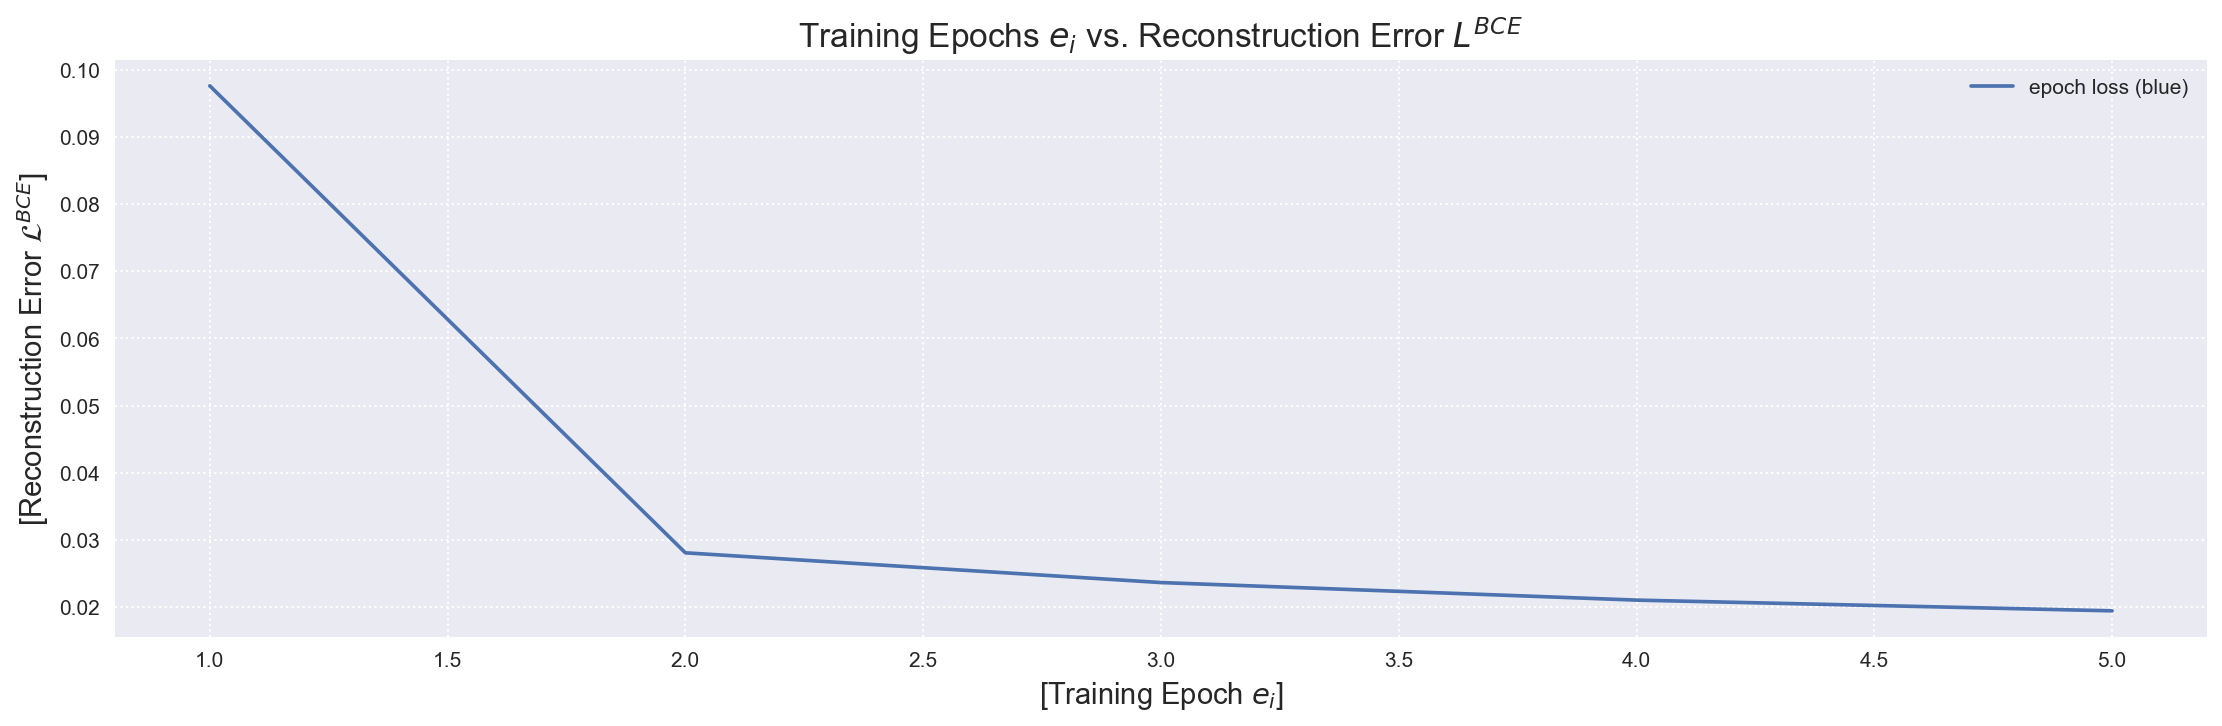

In [52]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(18)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' prediction error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[Training Epoch $e_i$]", fontsize=14)
ax.set_ylabel("[Reconstruction Error $\mathcal{L}^{BCE}$]", fontsize=14)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Reconstruction Error $L^{BCE}$', fontsize=16);

Es ist zu beobachten, dass der Rekonstruktionsfehler des AENN Models nach fünf Epochen kontinuierlich zu sinken beginnt. Diese Beobachtung deutet darauf hin, dass es dem Modell gelingt die innerhalb des Datensatzes enthaltenen Buchungen sukzessive zu lernen. Aus der Visualisierung wird jedoch auch ersichtlich, dass das Modell noch einige Epochen weiter trainiert werden könnte bis der Rekonstruktionsfehler nicht mehr abnihmt.

## 6. Evaluation des Autoencoder Neural Network Modells

In diesem Abschnitt möchten wir die Fähigkeit des Autoencoder basierten zur Erkennung von Anomalien in Buchhaltungsdaten evaluieren. Hierzu werden wir auf vortrainierte AENN Modelle zurück greifen. Die Evaluation umfasst die **lokalen** als auch die **globalen** innerhalb des Anomalien des Datensatzes. 

### 6.1 Laden eines Modell Checkpoints

Bevor wir mit der Auswertung beginnen, laden wir üblicherweise das AENN-Modell mit **geringstem Rekonstruktionsfehler** oder ein bereits vortrainiertes Modell. Innerhalb der obigen Trainingsroutine wurde jeweils pro Trainingsepoche ein Checkpoint der Modellparameter innerhalb des lokalen Modellverzeichnis gespeichert. Wir werden nun einen Checkpoint laden, der bereits für **30 Trainingsepochen** trainiert wurde:

In [54]:
# restore pretrained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/courseAAA/main/04_models/ep_30_encoder_model_small.pth'
decoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/courseAAA/main/04_models/ep_30_decoder_model_small.pth'

# read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)
decoder_bytes = urllib.request.urlopen(decoder_model_name)

# load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())
decoder_buffer = io.BytesIO(decoder_bytes.read())

# init evaluation encoder and decoder model
encoder_eval = encoder()
decoder_eval = decoder()

# push encoder and decoder model to compute device
encoder_eval = encoder_train.to(device)
decoder_eval = decoder_train.to(device)

# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer, map_location=lambda storage, loc: storage))
decoder_eval.load_state_dict(torch.load(decoder_buffer, map_location=lambda storage, loc: storage))

<All keys matched successfully>

### 6.2 Evaluation des Modells

Nach erfolgreichem Laden des Modell Checkpoints transferieren wie diesen für Evaluierungszwecke auf die `CPU`. Dies erlaubg uns alle individuellen Rekonstruktionen der Buchungen des Datensatzes Durchgang berechnen, ohne etwaige Einschränkungen bedingt durch den Arbeitsspeicher der GPU:

In [55]:
# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# push encoder and decoder model to compute device
encoder_eval = encoder_eval.to('cpu')
decoder_eval = decoder_eval.to('cpu')

# push the dataset to the CPU 
torch_dataset = torch_dataset.to('cpu')

# push the loss function to the CPU
loss_function = loss_function.to('cpu')

In einem nächsten Schritt berechnen wir die individuellen **BCE Rekonstruktionsfehler** für jede Buchung $x_{i}$ innerhalb des Datensatzes. Zu diesem Zweck wird zunächst die Rekonstruktion $\hat{x}_{i}$ jeder Buchung ermittelt. Anschliessend wird die rekonstruierte Buchung $\hat{x}_{i}$ mit der originalen Buchungen $x_{i}$ des Datensatzes über den **BCE Rekonstruktionsfehler** verglichen :

In [58]:
# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(torch_dataset))

# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], torch_dataset[i]).item()

    if(i % 10000 == 0):

        ### print conversion summary
        now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))

[LOG 2022.10.06-23:35:24] collected individual reconstruction loss of: 000000/091247 transactions
[LOG 2022.10.06-23:35:24] collected individual reconstruction loss of: 010000/091247 transactions
[LOG 2022.10.06-23:35:25] collected individual reconstruction loss of: 020000/091247 transactions
[LOG 2022.10.06-23:35:25] collected individual reconstruction loss of: 030000/091247 transactions
[LOG 2022.10.06-23:35:25] collected individual reconstruction loss of: 040000/091247 transactions
[LOG 2022.10.06-23:35:26] collected individual reconstruction loss of: 050000/091247 transactions
[LOG 2022.10.06-23:35:26] collected individual reconstruction loss of: 060000/091247 transactions
[LOG 2022.10.06-23:35:27] collected individual reconstruction loss of: 070000/091247 transactions
[LOG 2022.10.06-23:35:27] collected individual reconstruction loss of: 080000/091247 transactions
[LOG 2022.10.06-23:35:28] collected individual reconstruction loss of: 090000/091247 transactions


Anschliessend visualiseren wir die Höhe der jeweils berechneten individuellen Rekonstruktionsfehler:

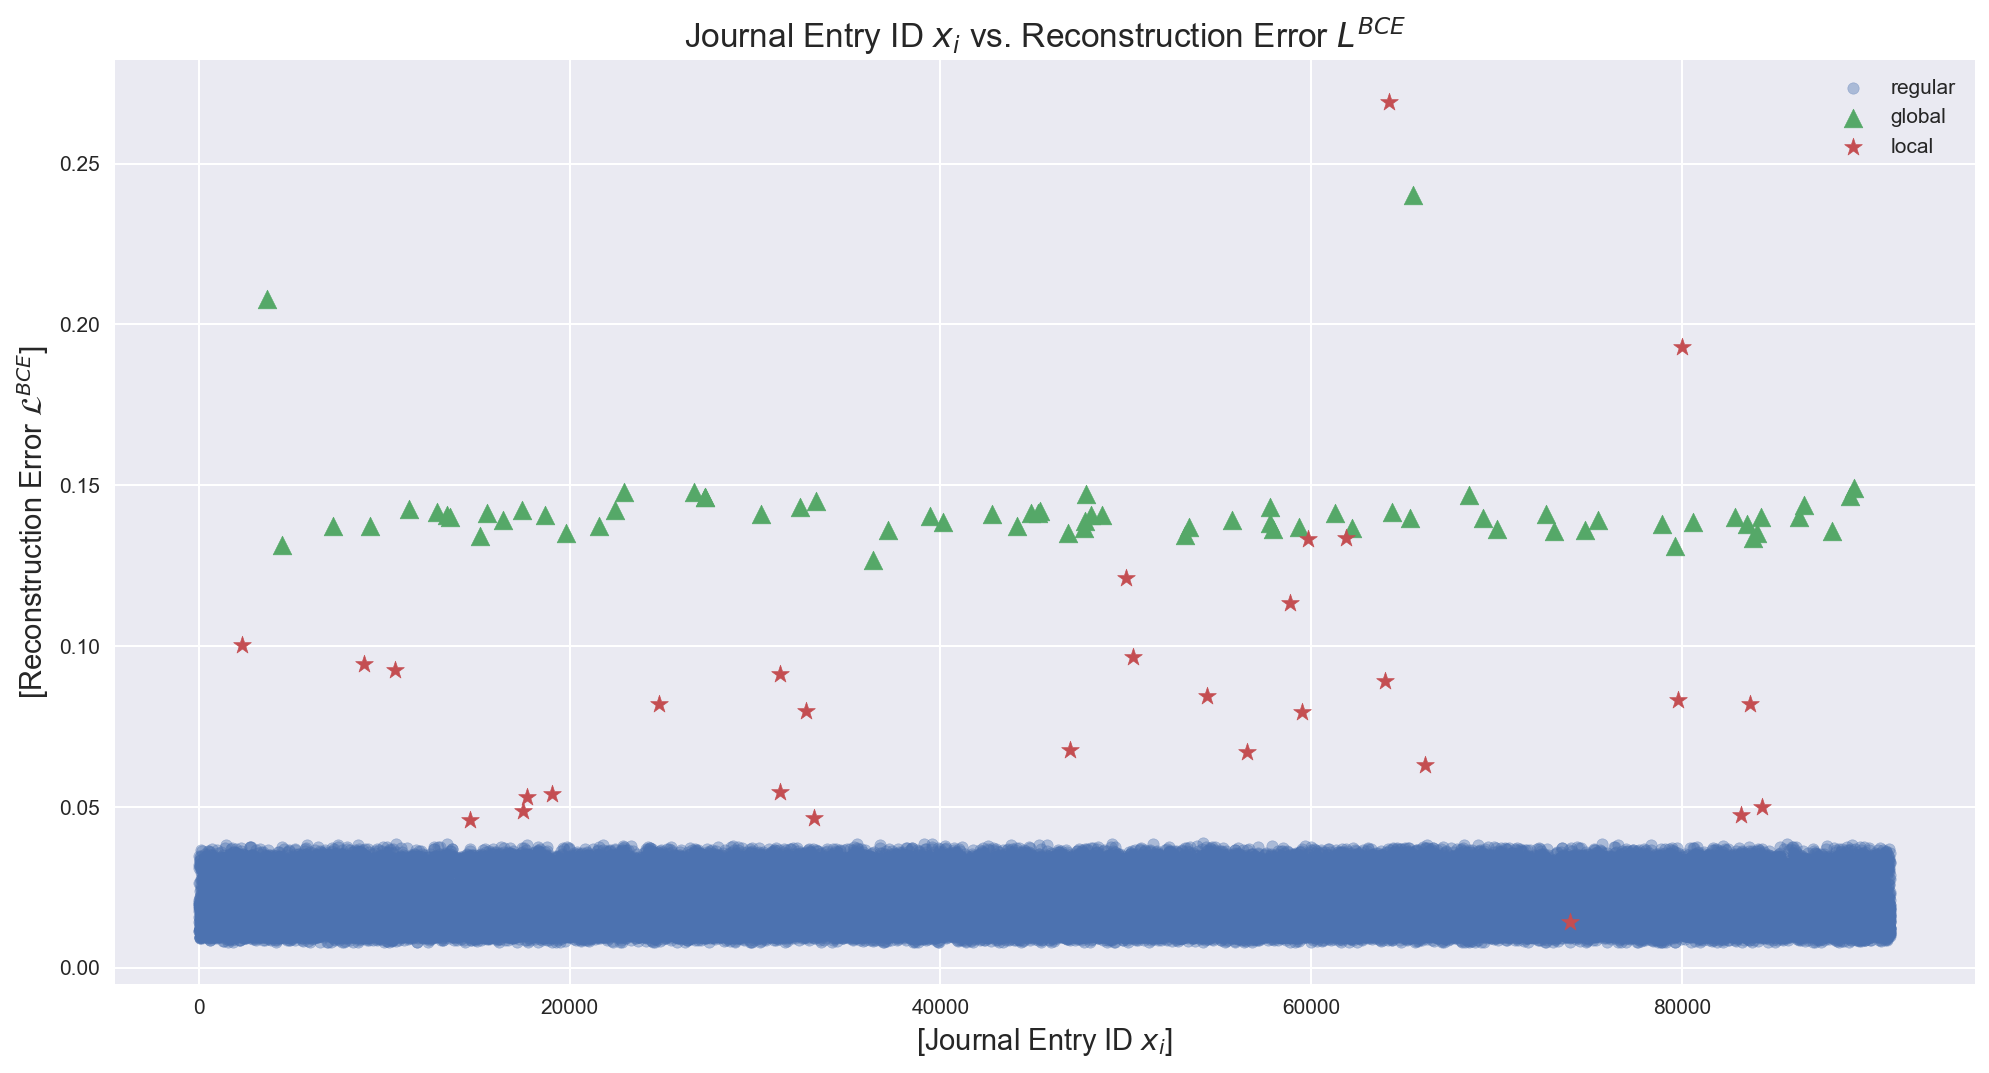

In [60]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# set plot size
fig.set_figwidth(16)
fig.set_figheight(8)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

# obtain regular transactions as well as global and local anomalies
regular_data = plot_data[label == 'regular']
global_outliers = plot_data[label == 'global']
local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", s=30, label='regular') # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", s=80, label='global') # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="*", s=80, label='local') # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best')

# add axis legends
ax.set_xlabel("[Journal Entry ID $x_i$]", fontsize=14)
ax.set_ylabel("[Reconstruction Error $\mathcal{L}^{BCE}$]", fontsize=14)

# add plot title
plt.title('Journal Entry ID $x_i$ vs. Reconstruction Error $L^{BCE}$', fontsize=16);

Die Visualisierung zeigt, dass das unser AENN Modell die meisten regulären Buchungen mit geringem Fehler rekonstruieren kann. Prallel weisen die **globalen Anomalien (grün)** als auch **lokalen Anomalien (rot)** einen Vergleichsweise hohen Rekonstruktionsfehler auf. Auf Grundlage dieses Analyseergebnis lässt sich konstatieren, dass der Rekonstruktionsfehler dazu verwendet werden, um **Anomalien (grün und rot)** von den regulären Buchungen (blau) des Buchungsstoffes zu unterscheiden.

Um diese Feststellung weiter zu untersuchen wollen wir nun die Buchungen, die einen **Rekonstruktionsfehler >= 0.12** aufweisen für substantielle Prüfungshandlungen filtern. Hierbei nehmen wir an, dass diese Buchungen **globalen Anomalien** des Buchungsstoffes entsprechen:

In [61]:
# append labels to original dataset
ori_dataset['label'] = label

# extract transactions exhibiting a reconstruction error >= 0.12
autoencoder_global_anomalies = ori_dataset[reconstruction_loss_transaction >= 0.12]

# inspect transactions exhibiting a reconstruction error >= 0.12
autoencoder_global_anomalies

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
3643,532930,G92,W69,K78,J13,W62,S49,92445535.21,59585050.56,global
4483,532954,J38,C30,G28,T38,C62,L03,92445511.29,59585034.34,global
7244,532974,U94,K13,K84,U04,N56,N94,92445503.32,59585040.04,global
9230,532973,W25,G35,K00,C11,B38,C25,92445498.62,59585051.03,global
11307,532959,C89,S43,E40,Y34,L29,N28,92445526.13,59585044.24,global
...,...,...,...,...,...,...,...,...,...,...
86321,532963,Z06,G77,Z22,R09,V09,X53,92445528.45,59585039.25,global
86606,532929,E59,R76,D30,M02,D16,B35,92445514.34,59585044.67,global
88134,532932,R07,U18,V96,L28,K79,K77,92445516.58,59585038.80,global
89091,532966,H54,Q11,X82,H69,J21,R89,92445515.72,59585046.47,global


Lassen Sie uns die gefilterten Transaktionen in eine Excel-Tabelle extrahieren, um diese dem Prüfungsteam zur Verfügung zu stellen. Hierzu werden wir in einem ersten Schritt einen Zeitstempel des Datenextrakts für den Audit-Trail der Prüfung erstellen:

In [62]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Anschliessend extrahieren wir die gefilterten **globalen Anomalien** als Excel-Datei zur weiteren Prüfung:

In [63]:
# specify the filename of the excel spreadsheet
filename = str(timestamp) + " - ACA_001_autoencoder_global_anomalies.xlsx"

# specify the target data directory of the excel spreadsheet
data_directory = os.path.join(results_directory, filename)

# extract the filtered transactions to excel
autoencoder_global_anomalies.to_excel(data_directory, header=True, index=False, sheet_name="Global_Anomalies", encoding="utf-8")

Schauen wir uns nun auch die Buchungen genauer an, die einen **Rekonstruktionsfehler >= 0.04 jedoch =< 0.12** aufweisen. Hierbei nehmen wir an, dass diese Buchungen **lokalen Anomalien** des Buchungsstoffes entsprechen:

In [64]:
# extract transactions exhibiting a reconstruction error < 0.12 and >= 0.04
autoencoder_local_anomalies = ori_dataset[(reconstruction_loss_transaction >= 0.04) & (reconstruction_loss_transaction < 0.12)]

# inspect transactions exhibiting a reconstruction error < 0.12 and >= 0.04
autoencoder_local_anomalies

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
2312,533007,C1,C11,C1,C78,A1,B1,910635.2878,54442.68859,local
8868,532983,C1,C11,C1,C72,A1,B1,910639.3765,54456.99952,local
10585,532994,C1,C11,C1,C76,A1,B1,910645.0762,54448.44020,local
14632,532992,C1,C11,C1,C57,A1,B1,910649.9255,54442.87996,local
17461,532996,C1,C11,C1,C93,A1,B1,910636.7098,54448.70394,local
17678,533008,C1,C11,C1,C90,A1,B1,910651.2760,54456.23481,local
19035,532991,C1,C11,C1,C91,A1,B1,910668.8875,54440.85658,local
24823,533009,C1,C11,C1,C32,A1,B1,910658.4585,54432.74266,local
31317,533002,C1,C11,C1,C60,A1,B1,910648.5451,54446.38283,local
31327,532985,C1,C11,C1,C75,A1,B1,910650.5090,54449.48313,local


Lassen Sie uns die gefilterten Transaktionen erneut in eine Excel-Tabelle extrahieren, um sie dem Prüfungsteam zur Verfügung zu stellen. Hierzu werden wir in einem ersten Schritt wieder Zeitstempel des Datenextrakts für den Audit-Trail der Prüfung erstellen:

In [65]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Anschliessend extrahieren wir die gefilterten **localen Anomalien** als Excel-Datei zur weiteren Prüfung:

In [66]:
# specify the filename of the excel spreadsheet
filename = str(timestamp) + " - ACA_002_autoencoder_local_anomalies.xlsx"

# specify the target data directory of the excel spreadsheet
data_directory = os.path.join(results_directory, filename)

# extract the filtered transactions to excel
autoencoder_local_anomalies.to_excel(data_directory, header=True, index=False, sheet_name="Local_Anomalies", encoding="utf-8")

## 7. Evaluation der Buchungsstoff Repräsentationen

In einem realen Szenario ist es in der Regel von Vorteil, zusätzlich die durch das AENN-Modell **erlernten Repräsentationen** der einzelnen Buchungen zu untersuchen. Die Untersuchung der Repräsentationen ermöglicht Rückschlüsse über die **strukturelle Semantik** des Buchungsstoffes und der Buchungsattribute. Darüber hinaus bietet eine solche Analyse bzw. Darstellung die Möglichkeit evtl. ermittelte Anomalien im Kontext des gesamten Buchungstoffes zu erklären. 

Um die gelernte Repräsentation für die Buchungen zu erhalten führen wir für jede Buchung einen Forwardpass durch den Encoder des AENN Model's durch. Die hierdurch erhaltenen drei-dimensionalen Repräsentationen werden anschliessend in einer entsprechenden Visualisierung dargestellt. Für die Durchführung des Forwardpass laden wir einen bereits für **80 Epochen trainierten Model Checkpoint** des Encoder Netzes:

In [67]:
# restore pretrained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/courseAAA/main/04_models/ep_80_encoder_model_small.pth'

# read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)

# load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())

# init evaluation encoder and decoder model
encoder_eval = encoder()

# push encoder and decoder model to compute device
encoder_eval = encoder_eval.to('cpu')

# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer, map_location=lambda storage, loc: storage))

<All keys matched successfully>

In einem nächsten Schritt führen wir den Forwardpass durch das Modell durch und erfassen die **drei-dimensionalen Koordinaten** der Repräsentationen:

In [68]:
# push the dataset to the CPU 
torch_dataset = torch_dataset.to('cpu')

# run forward path through encoder to obtain journal entry representations
entry_representations = encoder_eval(torch_dataset)

# convert the representations to a pandas dataframe
entry_representation = pd.DataFrame(entry_representations.data.cpu().numpy(), columns=['z1', 'z2', 'z3'])

Anschliessend versehen wir, für Visualisierungszwecke, die Repräsentationen mit den Labeln:

In [69]:
entry_representation['label'] = label

Wir werfen einen kurzen prüfenden Blick auf die erhaltenen Koordinaten:

In [70]:
entry_representation.head(10)

,z1,z2,z3,label
0,-6.409090,12.882844,95.381752,regular
1,-6.896410,24.001057,52.031860,regular
2,-7.684586,24.307302,70.182663,regular
3,-11.590373,42.750675,79.003227,regular
4,-7.081393,14.820823,102.584084,regular
5,-7.805017,24.851305,70.429100,regular
6,-5.836756,0.957955,141.852112,regular
7,-22.579536,88.615242,42.046707,regular
8,-15.027751,60.568302,66.610153,regular
9,-6.322841,23.694666,39.425270,regular


Beim Entwurf der Architektur des AENN Modells haben wir uns für Engpass-Schicht entschieden, die aus **3 Neuronen** besteht. Dies gibt uns die Möglichkeit, die Repräsentationen mit Hilfe der `Matplotlib` 3D-Funktionalität zu visualisieren. Eine entsprechende 3D Scatter Visualisierung Repräsentationen erhalten wir durch die Ausführung der nachfolgenden Zelle:

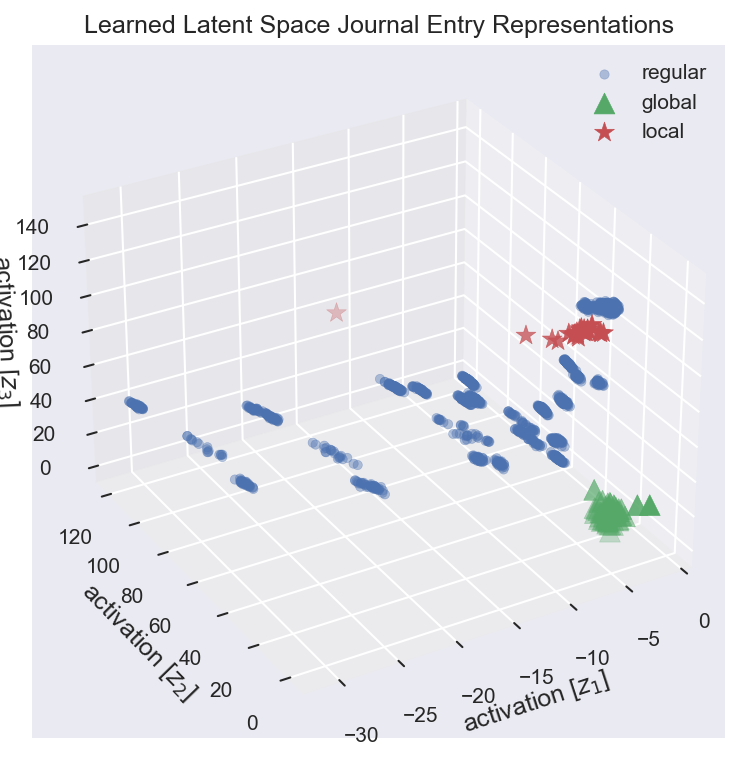

In [73]:
# enforce inline plotting
%matplotlib inline

# import 3d plotting and animation libraries
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d import axes3d

# init the plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# change plot perspective
ax.view_init(elev=30, azim=240)

# set axis paramaters of subplot
ax.grid(linestyle='dotted')

# plot regular transactions, just the first 1000 to gain an intuition
regular = entry_representation[entry_representation['label'] == 'regular']
ax.scatter(regular['z1'][0:2000], regular['z2'][0:2000], regular['z3'][0:2000], c='C0', alpha=0.4, marker="o", label='regular')

# plot first order anomalous transactions
global_anomalies = entry_representation[entry_representation['label'] == 'global']
ax.scatter(global_anomalies['z1'], global_anomalies['z2'], global_anomalies['z3'], c='C1', s=100, marker="^", label='global')

# plot second order anomalous transactions
local_anomalies = entry_representation[entry_representation['label'] == 'local']
ax.scatter(local_anomalies['z1'], local_anomalies['z2'], local_anomalies['z3'], c='C2', s=100, marker="*", label='local')

# set axis labels
ax.set_xlabel('activation [$z_1$]', weight='normal', fontsize=12)
ax.set_ylabel('activation [$z_2$]', weight='normal', fontsize=12)
ax.set_zlabel('activation [$z_3$]', weight='normal', fontsize=12)

# add plot legend of transaction classes
ax.legend(loc='best')

# set plot title
plt.title('Learned Latent Space Journal Entry Representations', fontsize=12);

## Lab Aufgaben:

Im Ihr wissen zu vertiefen empfehlen wir, die nachfolgenden Übungen zu bearbeiten:

**1. Apply a `dropout` throughout the network training.**

>Set the `dropout` probability to `0.2` (20%) and re-start the training procedure. What impact do you observe in terms of training performance and reconstruction loss? Please, note that after changing the `dropout` probability of the encoder and decoder model you need to execute all successive cells starting from section 4.2.

In [ ]:
# ***************************************************
# Sie können Ihre Lösung an dieser Stelle einfügen
# ***************************************************

**2. Trainieren und evaluieren Sie ein `shallow` Autoencoder Neural Network model.**

> Die innerhalb des Notebooks vorgestellte Modelarchitektur führte zu einer guten Genauigkeit bei der Erkennung von Anomalien. Schauen Sie sich an, wie sich der Rekonstruktionsfehler verändert, wenn **mehrere der versteckten Schichten** entfernt werden. Passen Sie hierzu die Encoder- und Decoder-Implementierungen entsprechend an (Sie können hierzu etwa das nachfolgend dargestellte Codebeispiel verwenden). Wie ändert sich die Fähigkeit des Modells Anomalien im Buchungsstoff zu erkennen? Lassen sich unterschiedliche Aussagen für globale bzw. lokale Anomalien treffen?

In [ ]:
# implementation of the shallow encoder network 
# containing only a single layer
class shallow_encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 3
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=3, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x)) # don't apply dropout to the AE bottleneck

        return x
    
# implementation of the shallow decoder network 
# containing only a single layer
class shallow_decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 618
        self.decoder_L1 = nn.Linear(in_features=3, out_features=ori_subset_transformed.shape[1], bias=True) # add linearity 
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x)) # don't apply dropout to the AE output
        
        return x

In [ ]:
# ***************************************************
# Sie können Ihre Lösung an dieser Stelle einfügen
# ***************************************************

## Lab Zusammenfassung

Diese Notebook umfasste eine schrittweise Einführung in **Entwurf, Implementierung, Training und Bewertung** eines auf einem neuronalen Netz basierenden Ansatzes zur Erkennung von Anomalien in Buchhaltungsdaten. Die vorgestellten Code Beispiele und die Übungen können als Ausgangspunkt für für die Entwicklung und das Testen komplexerer Strategien zur Erkennung von Anomalien dienen.